# MNIST using Sklearn MLP

#  Introduction

<div style="border-radius: 10px; border: #3bb143 solid; padding: 15px; background-color: #ffffff00; font-size: 100%; text-align: left;">
The <b>MNIST database</b> (<i>Modified National Institute of Standards and Technology database</i>) is a large database of <b>handwritten digits</b> that is commonly used for training various image processing systems. As new machine learning techniques emerge, MNIST remains a reliable resource for researchers and learners alike.<br><br>
The original <b>black and white images</b> were normalized to fit into a <b>28x28 pixel</b> bounding box and anti-aliased, which introduced <b>grayscale levels</b>. The original MNIST database contains 60,000 training images and 10,000 testing images, but in this competition we are given <b>42,000 training images</b> (70%) and <b>18,000 testing images</b> (30%). In the original paper, the creators used a <b>Support-Vector Machine</b> to get an <i>error rate of 0.8%</i>.<br><br>
In this notebook, we will train a <b>MultiLayer Perceptron (MLP)</b> that achieves a test accuarcy (Laderboard score) of <b>96.76%</b>. But first of all, we will <b>preprocess and visualize the data</b>. Then, we will train an MLP using the <code>sklearn</code> Python library. Finally, we will predict on the test data to create the <b>submission file</b>.<br><br>
</div>

In [1]:
## IMPORT THE NECESSARY PYTHON LIBRARIES

# Read and Preprocess Data
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Train a MultiLayer Perceptron
from tqdm import tqdm
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import \
    log_loss, accuracy_score, \
    confusion_matrix, ConfusionMatrixDisplay

# 🔎 Read & Preprocess Data 🔍

<div style="border-radius: 10px; border: #3bb143 solid; padding: 15px; background-color: #ffffff00; font-size: 100%; text-align: left;">
In this section, we will use the well-known <code>Pandas</code> Python library to read the data from <code>.csv</code> files.<br><br>
We will visualize the <b>distribution of the pixel values</b> (histogram) using the <code>Seaborn</code> and <b>Matplotlib</b> Python libraries. We will also check that there are no <b>missing values</b>, and that the <b>target classes are balances</b>. We will <b>visualize the images</b> by plotting one image from each class.<br><br>
The last part of this section consists of <b>preprocessing the data</b> before feeding an <b>MLP</b> model:
    <ul>
        <li> <b>SCALING</b> : Scale the data by mapping the pixel values to the <b>[0,1] interval</b>, where the largest occuring data point (<code>255</code>) corresponds to the maximum value (<code>1</code>), and the smallest one (<code>0</code>) corresponds to the minimum value (<code>0</code>). <br><b>WHY?</b> Because <i>MultiLayer Perceptrons</i> can benefit from having input data with small values. This encourages <i>numerical stability</i>, <i>gradient descent convergence</i>, <i>activation function sensitivity</i>, etc.</li><br>
        <li> <b>FLATTENING</b> : Each image will be represented as <b>an array of 784 values</b>. It means that we will not take advantage of the grid structure of the image.<br><b>WHY?</b> Because <i>MultiLayer Perceptrons</i> models were originally designed to handle <i>one-dimensional</i> input data. This limitation arises from the architecture of the <i>perceptron</i>, the fundamental building block of an MLP. In the context of images, a basic MLP would <i>treat each pixel as a separate input feature</i>, resulting in a flattened, one-dimensional representation of the image. This approach <i>loses the spatial information</i> and structure inherent in two-dimensional images</li>
    </ul>
</div>

In [2]:
# Read the data files using Pandas
df_train = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
df_test =  pd.read_csv('/kaggle/input/digit-recognizer/test.csv')

In [3]:
# Check the size of the train and test DataFrames
print("df_train shape:", df_train.shape)
print("df_test shape: ", df_test.shape)

df_train shape: (42000, 785)
df_test shape:  (28000, 784)


In [4]:
# Fortunately there are no missing values in our data
print(
    "Missing values in df_train: ", \
    df_train.isna().sum().sum()
)
print(
    "Missing values in df_test: ", \
    df_test.isna().sum().sum()
)

Missing values in df_train:  0
Missing values in df_test:  0


In [5]:
# Let's have a look at the first five training rows
df_train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
# We can see that the first colum is the label,
# and the rest of the columns are the 784 pixels
# that represent 28x28 gray-scale images.
# Let's extract the training images (X) and 
# the trainig targets (y)

X_train_original = df_train.drop(columns=['label']).values
X_train_2d = X_train_original.reshape(
    42000, 28, 28
)

y_train = df_train['label'].values

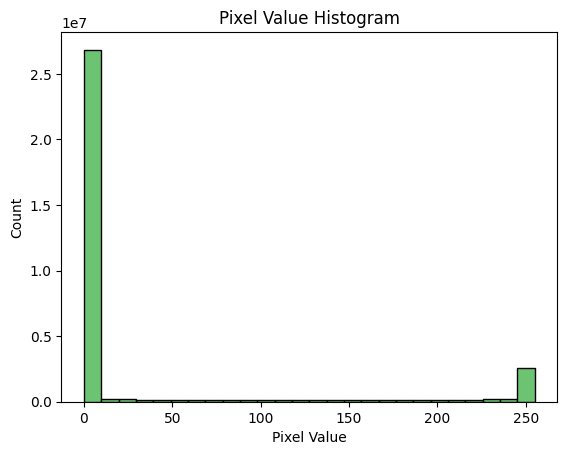

In [7]:
# Let's visualize the distribution of the pixel values

ax = sns.histplot(
    x=X_train_original.flatten(), 
    color='#3bb143'
)
_ = ax.set(
    title='Pixel Value Histogram', xlabel='Pixel Value'
)

# As we can see, the 0 value represents the background
# and the >0 values represent the digits in the images

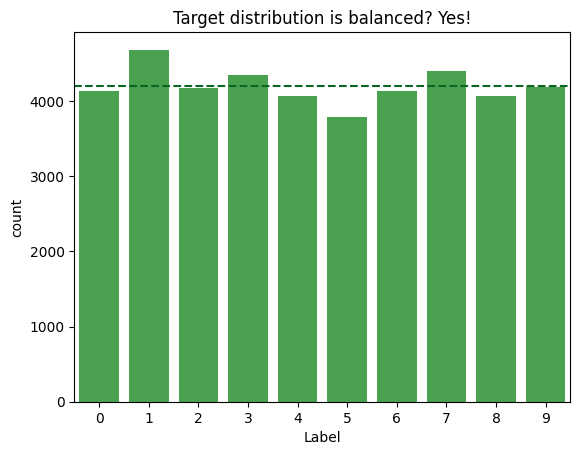

In [8]:
# Let's check that the target is balances.
# It means that the ten categories in the target
# have roughly the same representation in the data.

ax = sns.countplot(x=y_train, color='#3bb143')
ax.set(
    title='Target distribution is balanced? Yes!',
    xlabel='Label'
)
# The expected number of samples for a balanced 
# class distribution is 42000/10 = 4200
ax.axhline(y=4200, color='#0b6623', linestyle='--')

# Since the target classes are balances, we don't have
# worry about sampling methods and biases in our models.

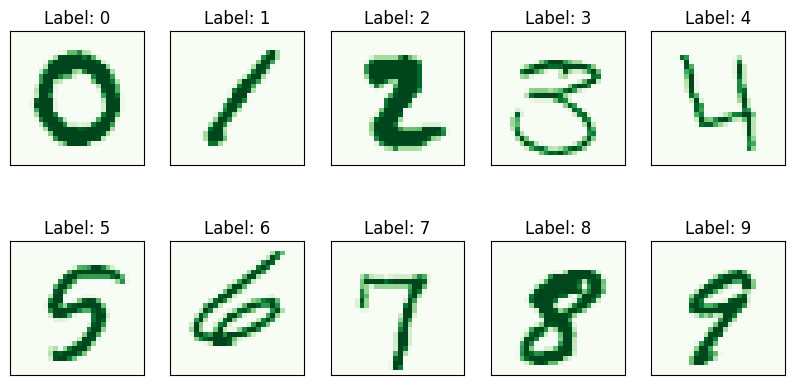

In [9]:
# Next, let's visualize one image from each class.
# We will use the matplotlib 'imshow' function.

fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(10,5))

for i in range(10):
    idx = np.where(y_train==i)[0][0]
    img = axs[int(i >= 5), i%5].imshow(
        X=X_train_2d[idx], cmap='Greens'
    )
    img.axes.get_yaxis().set_visible(False)
    img.axes.get_xaxis().set_visible(False)
    img.axes.set_title(f'Label: {i}')

In [10]:
# Finally, let's preprocess the data before feeding an MLP:
# Scaling & Flattening

X_min, X_max = X_train_original.min(), X_train_original.max()
X_train = (X_train_original - X_min) / (X_max - X_min)  # scaling
print("After applying Min-Max Scaler:")
print("  - New minimum value:", X_train.min())
print("  - New maximum value:", X_train.max())
print()

X_train = X_train.reshape(42000, -1)  # flattening
print("After flattening:")
print("  - New shape:", X_train.shape)

After applying Min-Max Scaler:
  - New minimum value: 0.0
  - New maximum value: 1.0

After flattening:
  - New shape: (42000, 784)


# Train a MultiLayer Perceptron

<div style="border-radius: 10px; border: #3bb143 solid; padding: 15px; background-color: #ffffff00; font-size: 100%; text-align: left;">
In this section, we will <b>train a MultiLayer Perceptron</b> classifier based on the preprocessed data from the previous section. We will use the <code>sklearn.neural_network.MLPClassifier</code>, which offers a convenient way to train poweful <i>Neural Networks</i>.<br><br>
A <b>MultiLayer Perceptron (MLP)</b> is a type of <i>artificial neural network</i> that consists of multiple layers of neurons, arranged in a series of <i>input</i>, <i>hidden</i>, and <i>output</i> layers. It is a <b>feedforward neural network</b>, meaning that information travels in one direction, from the <i>input layer</i> through the <i>hidden layers</i> to the <i>output layer</i>. The term <b>perceptron</b> refers to a single layer of neurons.<br><br>
Each connection between nodes in adjacent layers is associated with a <b>weight</b>. The weights determine the strength of the connections and are adjusted during the training process to enable the network to learn from data. Additionally, each node has an associated <b>bias</b>, which allows the model to learn constant offsets.<br><br>
Neurons in the hidden layers typically apply an <b>activation function</b> to the weighted sum of their inputs and biases. These functions <i>introduce non-linearities</i>, allowing the network to learn complex relationships in the data. Here we use the well-known <b>ReLU</b> (<i>Rectified Linear Unit</i>).<br><br>
The model is trained using a supervised learning approach called <b>backpropagation</b>. During training, the network adjusts its weights and biases to minimize the difference between predicted outputs and actual target values, guided by a <b>loss function</b>. For our multi-class classification task, we will use the <b>cross-entropy loss</b> (a.k.a <b>logarithmic loss</b>).
</div>

<div style="border-radius: 10px; border: #3bb143 solid; padding: 15px; background-color: #ffffff00; font-size: 100%; text-align: left;">
We will not use the <code>fit</code> method from the <code>sklearn.neural_network.MLPClassifier</code> module. Why? Because we want to track the training and validation accuracies and losses, and this method does not provide us with these values after each udpate. Fortunatelly, we can implement our own training loop using the <code>partial_fit</code> method, which updates the current model with the given data (next chunk of code!).<br><br>
At each epoch, we will split the data into batches and perform a <code>partial_fit</code> step. Then, we will compute the training and validation accuracies and losses, and store all of them in four python lists. After the training loop is completed, we will analyze these metrics.
</div>

In [11]:
# Let's split the training data into 
# train and validation subsets.
# The validation set will be used for
# evaluation purposes while fitting the
# model to the training subset.
# The validation set will allow us to 
# detect overfitting.

X_train_, X_valid_, y_train_, y_valid_ = train_test_split(
    X_train,
    y_train,
    test_size=0.05,  # 95% train, 5% validation
    stratify=y_train,  # split data in a stratified fashion
    random_state=2023
)

print('X_train_ shape =', X_train_.shape)
print('y_train_ shape =', y_train_.shape)
print('-' * 35)
print('X_valid_ shape =', X_valid_.shape)
print('y_valid_ shape =', y_valid_.shape)

X_train_ shape = (39900, 784)
y_train_ shape = (39900,)
-----------------------------------
X_valid_ shape = (2100, 784)
y_valid_ shape = (2100,)


In [12]:
# Initialize an MLPClassifier instance

mlp_clf = MLPClassifier(
    hidden_layer_sizes=[128, 32,],  # Neurons for each hidden layer
    activation='relu',  # Rectified Linear Unit (activation function)
    solver='adam',  # High-performance stochastic gradient-based optimizer
    alpha=5e-3,  # Strength of the L2 regularization term (added to the loss)
    learning_rate_init=5e-4,  # It controls the step-size in updating the weights
    shuffle=True,  # Whether to shuffle samples in each iteration (epoch)
    random_state=1234,  # RNG for weights and bias initialization
    verbose=0,  # Whether to print progress messages to stdout.
)

# NOTE that we don't specify the batch_size and the max_iter arguments
# We will apply them manually in the next chunk of code (partial_fit)

In [13]:
# Remaining hyperparameters:
n_epochs = 10
n_classes = 10  # from 0 to 9 (both included)
batch_size = 128  # Size of minibatches for stochastic optimizers

# Track the training and validation losses and accuracies
train_accuracies, valid_accuracies = [], []
train_losses, valid_losses = [], []

# Training loop:
for epoch in range(n_epochs):
    
    # Shuffle the training data
    shuffle_idx = np.random.permutation(len(X_train))
    X_epoch = X_train[shuffle_idx]
    y_epoch = y_train[shuffle_idx]
    print(f'epoch {epoch+1} / {n_epochs}:')
    
    for batch_first_idx in tqdm(range(0, len(y_train), batch_size)):
        
        # Get the data for the current batch
        batch_last_idx = min(batch_first_idx+batch_size, len(y_train))
        X_batch = X_epoch[batch_first_idx:batch_last_idx]
        y_batch = y_epoch[batch_first_idx:batch_last_idx]
        
        # Update the model with a single iteration over the given data.
        mlp_clf.partial_fit(X=X_batch, y=y_batch, classes=range(n_classes))
        
        # Compute and track training and validation losses
        batch_loss = log_loss(
            y_true=y_batch, 
            y_pred=mlp_clf.predict_proba(X=X_batch),
            labels=range(n_classes)
        )
        valid_loss = log_loss(
            y_true=y_valid_,
            y_pred=mlp_clf.predict_proba(X=X_valid_),
            labels=range(n_classes)
        )
        train_losses.append(batch_loss)
        valid_losses.append(valid_loss)
        
        # Compute and track training and validation accuracies
        batch_acc = accuracy_score(
            y_true=y_batch, 
            y_pred=mlp_clf.predict(X=X_batch),
        )
        valid_acc = accuracy_score(
            y_true=y_valid_, 
            y_pred=mlp_clf.predict(X=X_valid_),
        )
        train_accuracies.append(batch_acc)
        valid_accuracies.append(valid_acc)

    print(f'    train losses = {round(np.mean(train_losses[-100:]), 4)}')
    print(f'    valid losses = {round(np.mean(valid_losses[-100:]), 4)}')
    print(f'    train acc = {round(np.mean(train_accuracies[-100:]), 4)}')
    print(f'    valid acc = {round(np.mean(valid_accuracies[-100:]), 4)}')
    print('-' * 50)

epoch 1 / 10:


100%|██████████| 329/329 [00:19<00:00, 16.60it/s]


    train losses = 0.2713
    valid losses = 0.291
    train acc = 0.9217
    valid acc = 0.921
--------------------------------------------------
epoch 2 / 10:


100%|██████████| 329/329 [00:18<00:00, 17.59it/s]


    train losses = 0.201
    valid losses = 0.2066
    train acc = 0.941
    valid acc = 0.9395
--------------------------------------------------
epoch 3 / 10:


100%|██████████| 329/329 [00:20<00:00, 16.39it/s]


    train losses = 0.1532
    valid losses = 0.1655
    train acc = 0.9556
    valid acc = 0.9495
--------------------------------------------------
epoch 4 / 10:


100%|██████████| 329/329 [00:18<00:00, 17.36it/s]


    train losses = 0.1313
    valid losses = 0.1405
    train acc = 0.9639
    valid acc = 0.956
--------------------------------------------------
epoch 5 / 10:


100%|██████████| 329/329 [00:19<00:00, 16.50it/s]


    train losses = 0.1109
    valid losses = 0.1191
    train acc = 0.9688
    valid acc = 0.9631
--------------------------------------------------
epoch 6 / 10:


100%|██████████| 329/329 [00:19<00:00, 16.53it/s]


    train losses = 0.1001
    valid losses = 0.1054
    train acc = 0.9713
    valid acc = 0.9677
--------------------------------------------------
epoch 7 / 10:


100%|██████████| 329/329 [00:18<00:00, 17.32it/s]


    train losses = 0.0779
    valid losses = 0.0898
    train acc = 0.9801
    valid acc = 0.9736
--------------------------------------------------
epoch 8 / 10:


100%|██████████| 329/329 [00:19<00:00, 16.51it/s]


    train losses = 0.0706
    valid losses = 0.0815
    train acc = 0.9805
    valid acc = 0.9752
--------------------------------------------------
epoch 9 / 10:


100%|██████████| 329/329 [00:19<00:00, 16.89it/s]


    train losses = 0.0632
    valid losses = 0.0712
    train acc = 0.9825
    valid acc = 0.9799
--------------------------------------------------
epoch 10 / 10:


100%|██████████| 329/329 [00:19<00:00, 17.16it/s]

    train losses = 0.0595
    valid losses = 0.0637
    train acc = 0.984
    valid acc = 0.9817
--------------------------------------------------


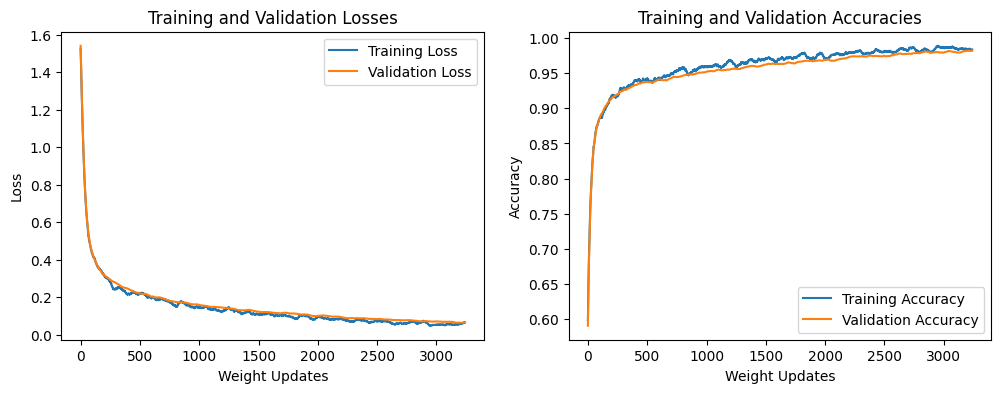

In [14]:
# Plot the training and validation curves (losses and accuracies)
# Implement a moving_average transformation to smooth the curves

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

window_size = 50

# Plot training and validation losses
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(
    moving_average(train_losses, w=window_size),
    label='Training Loss'
)
plt.plot(
    moving_average(valid_losses, w=window_size),
    label='Validation Loss'
)
plt.title('Training and Validation Losses')
plt.xlabel('Weight Updates')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracies
plt.subplot(1, 2, 2)
plt.plot(
    moving_average(train_accuracies, w=window_size),
    label='Training Accuracy'
)
plt.plot(
    moving_average(valid_accuracies, w=window_size),
    label='Validation Accuracy'
)
plt.title('Training and Validation Accuracies')
plt.xlabel('Weight Updates')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

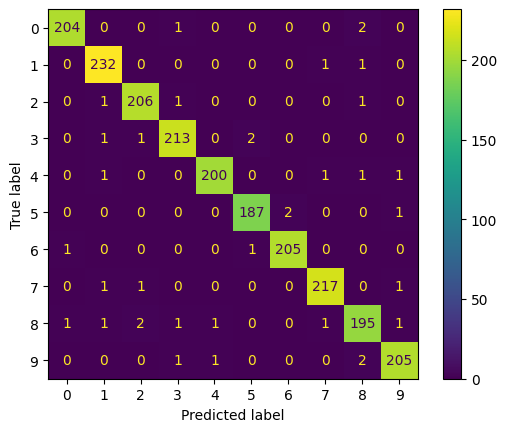

In [15]:
# Compute and display
y_valid_pred = mlp_clf.predict(X=X_valid_)
conf_matrix = confusion_matrix(
    y_true=y_valid_, 
    y_pred=y_valid_pred
)
conf_matrix_disp = ConfusionMatrixDisplay(conf_matrix)
conf_matrix_disp.plot()

# 👀 Visualize the learned weights 👀

<div style="border-radius: 10px; border: #3bb143 solid; padding: 15px; background-color: #ffffff00; font-size: 100%; text-align: left;">
    After training the model, we can <b>visualize the learned weights</b>. However, the interpreation is not always possible.<br><br>
Visualize MLP Filters. [<a href=https://scikit-learn.org/stable/auto_examples/neural_networks/plot_mnist_filters.html#sphx-glr-auto-examples-neural-networks-plot-mnist-filters-py>LINK</a>]
</div>

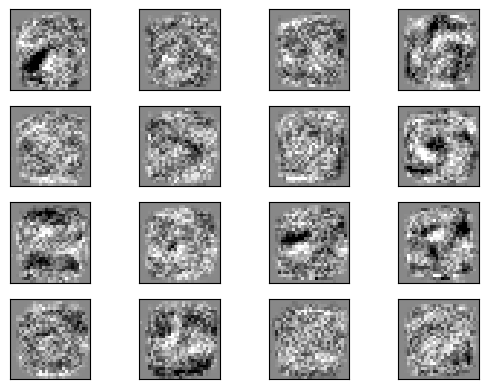

In [16]:
fig, axes = plt.subplots(4, 4)

# Use global min / max to ensure all weights are shown on the same scale
vmin, vmax = mlp_clf.coefs_[0].min(), mlp_clf.coefs_[0].max()

for coef, ax in zip(mlp_clf.coefs_[0].T, axes.ravel()):
    ax.matshow(
        coef.reshape(28, 28), 
        cmap=plt.cm.gray, 
        vmin=0.5 * vmin, 
        vmax=0.5 * vmax
    )
    ax.set_xticks(())
    ax.set_yticks(())

plt.show()

#  Create the final file 

<div style="border-radius: 10px; border: #3bb143 solid; padding: 15px; background-color: #ffffff00; font-size: 100%; text-align: left;">
    In this section, we will <b>train a new model with the entire training dataset</b> (training subset + validation subset). But before that, we will <b>preprocess the test data</b> applying the exact same preprocessing steps we applied to the training data. Finally, we will <b>create the final file with the test predictions</b>. 
</div>

In [17]:
# Preprocess the Test data: Scale and Flatten
X_test = df_test.values

X_min, X_max = X_train_original.min(), X_train_original.max()
X_test = (X_test - X_min) / (X_max - X_min)
print("After applying Min-Max Scaler:")
print("  - New minimum value:", X_test.min())
print("  - New maximum value:", X_test.max())
print()

X_test = X_test.reshape(len(df_test), -1)  # flattening
print("After flattening:")
print("  - New shape:", X_test.shape)

# NOTE: to compute the min and max values
# we use the training data to avoid DATA LEAKAGE.

After applying Min-Max Scaler:
  - New minimum value: 0.0
  - New maximum value: 1.0

After flattening:
  - New shape: (28000, 784)


In [18]:
# Initalize the final MLPClassifier
final_mlp_clf = MLPClassifier(
    hidden_layer_sizes=[128, 32,],
    activation='relu',
    solver='adam',
    alpha=5e-3,
    batch_size=batch_size,  # our batch_size value
    learning_rate_init=5e-4,
    max_iter=n_epochs,  # our n_epochs value
    shuffle=True,
    random_state=1234,
    verbose=10,
)

# Fit the model using the entire training dataset
final_mlp_clf.fit(X=X_train, y=y_train)

Iteration 1, loss = 0.57275635
Iteration 2, loss = 0.22911568
Iteration 3, loss = 0.17819196
Iteration 4, loss = 0.14866860
Iteration 5, loss = 0.12713300
Iteration 6, loss = 0.10864079
Iteration 7, loss = 0.09550027
Iteration 8, loss = 0.08370695
Iteration 9, loss = 0.07462213
Iteration 10, loss = 0.06855255


/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(alpha=0.005, batch_size=128, hidden_layer_sizes=[128, 32],
              learning_rate_init=0.0005, max_iter=10, random_state=1234,
              verbose=10)

In [19]:
# Once the model is trained using the trainign data,
# make predictions on the test data
predictions = final_mlp_clf.predict(X=X_test)
print('Test predictions = \n', predictions)

Test predictions = 
 [2 0 9 ... 3 9 2]
